In [15]:
import pandas as pd
import names
import numpy as np
from sklearn import datasets
from collections import defaultdict
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
import random

In [16]:
# Helper Methods
def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

def binaryArrayGenerator(n, p): #where n is num values and p is the probability of success (1)
    x = np.zeros(n)
    num = int(p*100)
    x[:num] = 1
    np.random.shuffle(x)
    return x

def genSubGaussianDist(dist1, dist2, n, dist1_percent, shuffle):
    x = np.random.normal(dist1["mean"], dist1["var"], int(dist1_percent * n))
    y = np.random.normal(dist2["mean"], dist2["var"], n - int(dist1_percent * n))
    z = np.append(x, y)
    if shuffle:  return np.random.shuffle(z)
    return z
    
def generateNames(sex, n):
    nameList = []
    for x in range (n):
        name = names.get_full_name(gender = sex)
        nameList.append(name)
    return nameList

# Takes in a probs array and a label array and generates an array of size numPpl based on proportions
# in the probs array.  Ppl * probs MUST BE = an INTEGER!
def generateFields(probs, labels, ppl):
    fields = []
    for x in range(len(probs)):
        fields += [labels[x] for y in range(int(ppl*probs[x]))]
    return fields

In [17]:
def genEducationalFields(numPpl, noCollegeProb=.05): 
    # 4 fields generated: education, type of undergraduate degree, educational prestige, and Athletics
    # Education - 0, 1, 2 ==> Wherein 0=High School Diploma, 1=Bachelors, 2=Graduate degree
    educProbs = [noCollegeProb, .75, .2]
    assert(sum(educProbs) == 1.0)
    educLabels = [0, 1, 2]
    educFields = generateFields(educProbs, educLabels, numPpl)
    #Type of Undergrad Degree
    degreeProbs = [noCollegeProb, .25, .20, .25, .25]
    assert(sum(degreeProbs) == 1.0)
    degreeLabels = ["None", "Humanities", "Sciences", "Quantitative", "Engineering"]
    degreeFields = generateFields(degreeProbs, degreeLabels, numPpl)

    #Educational Prestige ==> none, low-tier, mid-tier, high-tier
    prestigeProbs = [noCollegeProb, .3, .5, .15]
    assert(sum(prestigeProbs) == 1)
    prestigeLabels = [0, 1, 2, 3]
    prestigeFields = generateFields(prestigeProbs, prestigeLabels, numPpl)

    #Sports ==> None, Club/Intramural, NCAA
    sportsProbs = [noCollegeProb + .55, .3, .1]
    assert(int(sum(sportsProbs)) == 1)
    sportsLabels = ["None", "Club/Intramural", "NCAA/Professional"]
    sportsFields = generateFields(sportsProbs, sportsLabels, numPpl)

    ## Randomizing
    dependentIndexCutoff = int(noCollegeProb * numPpl)
    neweducFields, newdegreeFields, newprestigeFields, newsportsFields = educFields[dependentIndexCutoff:], degreeFields[dependentIndexCutoff:],prestigeFields[dependentIndexCutoff:], sportsFields[dependentIndexCutoff:]
    random.shuffle(neweducFields)
    random.shuffle(newdegreeFields)
    random.shuffle(newprestigeFields)
    random.shuffle(newsportsFields)
    
    for x in range(dependentIndexCutoff):
        indexToInsert = random.randint(0, len(neweducFields)-1)
        neweducFields.insert(indexToInsert, educLabels[0])
        newdegreeFields.insert(indexToInsert, degreeLabels[0])
        newprestigeFields.insert(indexToInsert, prestigeLabels[0])
        newsportsFields.insert(indexToInsert, sportsLabels[0])
           
    #### NEED TO RANDOMIZE THE NON noCollege ppl. 
    return neweducFields, newdegreeFields, newprestigeFields, newsportsFields

In [18]:
# We expect prob to be a tuple wherein the 0th element is the % of individuals in dataset
# with an arrest record and the 1th element is the % of individuals with a criminal record
# Returns a tuple of arrays where the first element is the array for arrestHistory, and the second is
# for criminal history
def genCriminalAndArrestRecords(numPpl, probs):
    assert(probs[0] > probs[1]) #Ensures that the number of arrests is greater than the num of those with criminal records
    # Criminal & Arrest
    dependentIndexCutoff = int(probs[1] * numPpl)
    criminalHistory = binaryArrayGenerator(numPpl, probs[1])
    arrestHistory = binaryArrayGenerator(numPpl, probs[0])
    newCrimHistory, newArrestHistory = list(criminalHistory[dependentIndexCutoff:]), list(arrestHistory[dependentIndexCutoff:])
    random.shuffle(newCrimHistory)
    random.shuffle(newArrestHistory)
    for x in range(dependentIndexCutoff):
        indexToInsert = random.randint(0, len(newCrimHistory)-1)
        newCrimHistory.insert(indexToInsert, 1)
        newArrestHistory.insert(indexToInsert, 1)
    return (newArrestHistory, newCrimHistory)

def genSensitiveAttributes(numPpl):
    # Sensitive Attributes
    raceValues = {"Caucasian": 0, "African-American": 1, "Asian": 2, "Hispanic": 3, "Other": 4}
    raceLabels = [0, 1, 2, 3, 4]
    raceProbs = [.7, .1, .1, .05, .05]
    raceFields = generateFields(raceProbs, raceLabels, numPpl)
    print(raceFields)
    print(len(raceFields))
    print(numPpl)
    if (len(raceFields) != numPpl):
        print("The generated length of array is not equal to the numPpl requested, double-check your race-probs against the num ppl you want to generate.")
    
    assert(len(raceFields) == numPpl)
    
    random.shuffle(raceFields)
    
    sexValues = {"Male": 0, "Female": 1}
    maleRatio = .6
    femaleRatio = .4

    maleNames = generateNames('male', int(maleRatio*numPpl))
    femaleNames = generateNames('female', int(femaleRatio*numPpl))
    nameFields = maleNames + femaleNames
    nameToSex = {name: 0 for name in maleNames}
    nameToSex2 = {name: 1 for name in femaleNames}
    nameToSex.update(nameToSex2)
    random.shuffle(nameFields)
    
    sexFields = [nameToSex[name] for name in nameFields]
    assert(len(sexFields) == numPpl)
    
    ages = get_truncated_normal(mean=25, sd=5, low=21, upp=60)
    ageFields = np.rint(ages.rvs(numPpl))
#     ageDist1 = defaultdict(float)
#     ageDist1["mean"] = 28 #years old
#     ageDist1["var"] = 6
#     ageDist2 = defaultdict(float)
#     ageDist2["mean"] = 50 #years old
#     ageDist2["var"] = 3
#     ageFields = np.rint(genSubGaussianDist(ageDist1, ageDist2, numPpl, .75, False))
    assert(len(ageFields) == numPpl)
    
    return nameFields, raceFields, sexFields, ageFields

In [19]:
# Birth Origin
def genBirthOrigin(ppl):
    countries = ["United States", "China", "Mexico", "India", "Canada", "Australia"]
    countryProbs = [.85, .05, .02, .03, .03, .02]
    candidateCountries = []
    for x in range(len(countryProbs)):
        candidateCountries += [countries[x] for y in range(int(ppl*countryProbs[x]))]
#     print(len(candidateCountries))
    return candidateCountries

# LinkedIn
def genLinkedinScore(ppl):
    linkedinScore = []
    probs = [.30, .50, .20] # Percentage of students with low-tier - (0), mid-tier(1), high tier university(2)
    for x in range(len(probs)):
        linkedinScore += [x for y in range(int(ppl*probs[x]))]
    return linkedinScore


In [6]:
# Build the list of features we desire to include in our rough hiring platform data
# Put yourself in pymetrics' shoes where a Fortune 500 comes to them and asks them to evaluate the following candidates for 
# a entry-level product management / business analyst / sales associate position.
# given their employee selection tests.

# What data parameters would enable you to make the best decision?
# Level of education, GPA, technical aptitude, soft skills, cultural fit, average commute time, address, languagues, years of work experience, number of 
# companies worked for, average stay at each company, past recommendations, Employee Referral, awards from previous work, race, gender, leadership experience, criminal history, 
# LinkedIn profile score, Instagram/Facebook/Twitter content is reasonable. 
# Communication, Problem Solving, Willing To Learn, Emotional Skills, Cognitive Ability.

features = ["Names", "GPA", "Avg Commute Time", "Cultural Fit", "Technical Aptitude", 
           "Soft Skills", "Employee Referral", "Years of Experience", "Leadership Capability", 
           "Race", "Sex", "Age", "Birth Origin", "Education", 
           "Undergraduate Degree", "Educational Prestige", "Sports", "Criminal Record",
           "Arrest Records", "LinkedIn Score", "Responsible Social Media Use", "HireVue Score"]

print(len(features))

22


In [20]:

def loadDataset(numPpl, features):
    print("Loading the dataset .... this might take a few seconds!")
    dataset = pd.DataFrame(columns = features)
    #Traditional Features
    GPAs = get_truncated_normal(mean=3.2, sd=0.5, low=0, upp=4.33)
    GPA = GPAs.rvs(numPpl) #mean, stdev, numSamples out of 4.0
    commuteTimes = get_truncated_normal(mean=25, sd=40, low=0, upp=120) #mean, stdev, numSamples in minutes
    techAptitude = np.random.choice(5, numPpl) # represent num of technical platforms proficient in. 
    culturalFit = np.random.choice(3, numPpl) # Where higher means their beliefs align with org more. 
    softSkills = binaryArrayGenerator(numPpl, .7)
    np.random.shuffle(softSkills)
    employeeReferral =binaryArrayGenerator(numPpl, .33) 
    np.random.shuffle(employeeReferral)
    yearsExperience = get_truncated_normal(mean=3, sd = 2, low = 0, upp=6)
    leadershipCapability = np.random.normal(.5, .25, numPpl)    
    nameFields, raceFields, sexFields, ageFields = genSensitiveAttributes(numPpl)

    #Load our additional Features in
    birthOrigin = genBirthOrigin(numPpl)
    random.shuffle(birthOrigin)
    percentageResponsible = .75
    responsibleSocmediaUse = binaryArrayGenerator(numPpl, percentageResponsible*numPpl)
    np.random.shuffle(responsibleSocmediaUse)
    hirevueScore = np.random.choice(3, numPpl)
    linkedinScore = genLinkedinScore(numPpl)
    random.shuffle(linkedinScore)
    arrestRecords, criminalRecords = genCriminalAndArrestRecords(numPpl, (.1, .05))
    educFields, degreeFields, prestigeFields, sportsFields = genEducationalFields(numPpl, noCollegeProb=.05)

    # Load those values into our dataset. 
    dataset["Names"] = nameFields
    dataset["GPA"] = GPA
    dataset["Avg Commute Time"] = commuteTimes.rvs(numPpl)
    dataset["Technical Aptitude"] = techAptitude
    dataset["Cultural Fit"] = culturalFit
    dataset["Soft Skills"] = softSkills
    dataset["Employee Referral"] = employeeReferral
    dataset["Years of Experience"] = np.rint(yearsExperience.rvs(numPpl))
    dataset["Leadership Capability"] = leadershipCapability
    dataset["Race"] = raceFields
    dataset["Sex"] = sexFields
    dataset["Age"] = ageFields
    dataset["Birth Origin"] = birthOrigin
    dataset["Education"] = educFields
    dataset["Undergraduate Degree"] = degreeFields
    dataset["Educational Prestige"] = prestigeFields
    dataset["Sports"] = sportsFields
    dataset["Criminal Record"] = criminalRecords
    dataset["Arrest Records"] = arrestRecords
    dataset["LinkedIn Score"] = linkedinScore
    dataset["Responsible Social Media Use"] = responsibleSocmediaUse 
    dataset["HireVue Score"] = hirevueScore
    return dataset


In [21]:
dataset = loadDataset(500, features)   
dataset
dataset.to_csv("dataset.csv")

Loading the dataset .... this might take a few seconds!
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [22]:
modelEmployees = loadDataset(100, features)
modelEmployees
modelEmployees.to_csv("modelEmployees2.csv")

Loading the dataset .... this might take a few seconds!
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4]
100
100


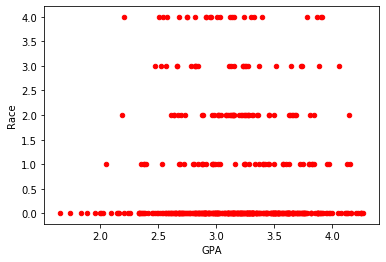

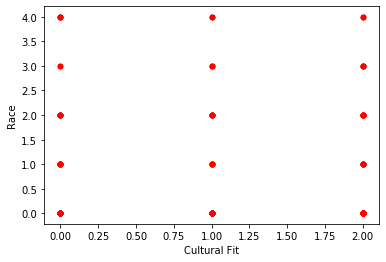

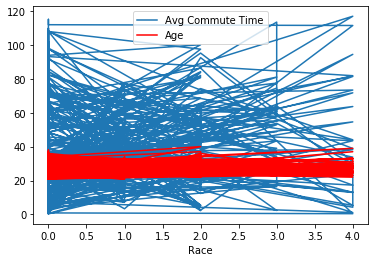

In [23]:
#### Graphing some basic relations
dataset.plot(kind='scatter',x='GPA',y='Race',color='red')
plt.show()

dataset.plot(kind='scatter',x='Cultural Fit',y='Race',color='red')
plt.show()


ax = plt.gca()

dataset.plot(kind='line',x='Race',y='Avg Commute Time',ax=ax)
dataset.plot(kind='line',x='Race',y='Age', color='red', ax=ax)

plt.show()


In [14]:
###---- Now attempt to violate disparate impact clauses ---###
mCulturalFit = np.random.normal(2, .5, 60)
fCulturalFit = np.random.normal(0.5, .5, 40)
biasedCulturalFit = np.append(mCulturalFit, fCulturalFit)

dataset["Cultural Fit"] = biasedCulturalFit
dataset.plot(kind='scatter',x='Sex',y='Cultural Fit',color='red')
plt.show()


ValueError: Length of values does not match length of index